https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Import Required Pkgs

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.offline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

import pylab
from scipy import stats
import random

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50000)

# Import Data

In [4]:
data_dir = Path('../../data')
data_input = data_dir / 'energydata_complete.csv'
data_output = Path('/')

In [5]:
df = pd.read_csv(data_input,parse_dates = True,infer_datetime_format = True)

In [6]:
df.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4       RH_4         T5   RH_5        T6  \
0  19.79  44.730000  19.000000  45.566667  17.166667  55.20  7.026667   
1  19.79  44.790000  19.000000  45.992500  17.166667  55.20  6.833333   
2  19.79  44.933333  18.926667  45.890000  17.166667  55.09  6.560000   
3  19.79  45.000000  18.890000  45.723333  17.166667  55.09  6.433333   
4  19.79  45.000000  18.890000  45.530000  17.200000  55.09  6.366667   

        RH_6         T7       RH_7    T8       RH_8         T9   RH_9  \
0  84.256667  17.200000  41.626667  18.2  48.900000  17.033333  45.53   
1  84.063333  17.200000  41.560000  18.2  48.863333  17.066667  45.56   
2  83.156667  17.200000  41.433333  18.2  48.730000  17.000000  45.50   
3  83.423333  17.133333  41.290000  18.1  48.590000  17.000000  45.40   
4  84.893333  17.200000  41.230000  18.1  48.590000  17.000000  45.40   

      T_out  Press_mm_hg  RH_out  Windspeed  Visibility  Tdewpoint        rv1  \
0  6.600000        733.5    92.0   7.000000   63.000000        5.3  13.275433   
1  6.483333        733.6    92.0   6.666667   59.166667        5.2  18.606195   
2  6.366667        733.7    92.0   6.333333   55.333333        5.1  28.642668   
3  6.250000        733.8    92.0   6.000000   51.500000        5.0  45.410389   
4  6.133333        733.9    92.0   5.666667   47.666667        4.9  10.084097   

         rv2  
0  13.275433  
1  18.606195  
2  28.642668  
3  45.410389  
4  10.084097

In [7]:
df.drop(['lights','rv1','rv2'],inplace=True,axis = 1)

In [8]:
df_columns = df.columns
numericCols = df._get_numeric_data().columns

categoricalCols = list(set(df_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)

The categorical columns in transaction data are:  ['date']


# EDA

In [9]:
df.isnull().sum()

date           0
Appliances     0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
dtype: int64

In [10]:
pandas_profiling.ProfileReport(df)

# Feature engineering and Selection

In [11]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month']= df['date'].dt.month
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.dayofweek

In [12]:
for col in ['year','month','weekday','hour']:
    print(df[col].unique())

[2016]
[1 2 3 4 5]
[0 1 2 3 4 5 6]
[17 18 19 20 21 22 23  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [13]:
for col in ['month','weekday','hour']:
     df[col] = df[col].astype('category')

In [14]:
#drop highly correlated vars
df.drop(['date','year','T9','T_out'],axis = 1,inplace = True)

In [15]:
pandas_profiling.ProfileReport(df[['Appliances','month','weekday','hour']])

In [16]:
#convert categories to dummy variables
df.groupby('month').sum().Appliances

month
1    283510
2    421550
3    432800
4    427200
5    362950
Name: Appliances, dtype: int64

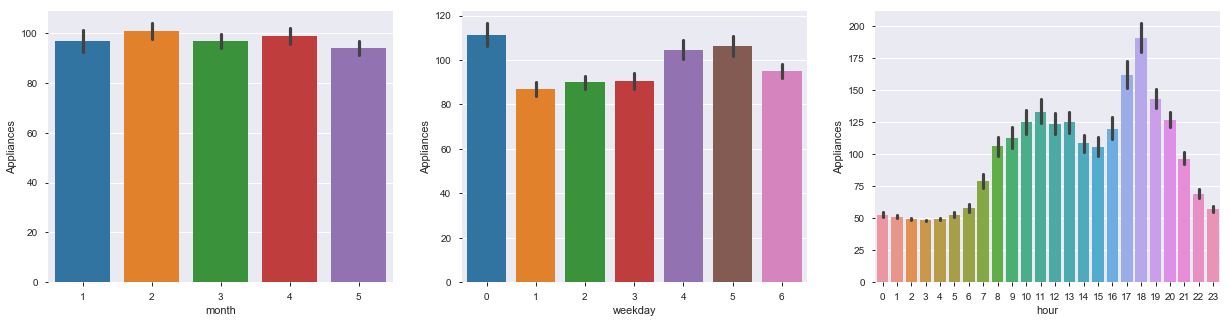

In [17]:
plt.figure(figsize = (21,5))
plt.subplot(1,3,1)
sns.barplot(x = df.month,y = df.Appliances)
plt.subplot(1,3,2)
sns.barplot(x = df.weekday,y = df.Appliances)
plt.subplot(1,3,3)
sns.barplot(x = df.hour,y = df.Appliances)
plt.show()

In [18]:
#convert categorical variables to dummy binary vars
month_dummy = pd.get_dummies(df.month, drop_first=True)
hour_dummy = pd.get_dummies(df.hour, drop_first=True)
weekday_dummy = pd.get_dummies(df.weekday, drop_first=True)

In [19]:
df = pd.concat([df , month_dummy,hour_dummy,weekday_dummy],axis = 1)

In [20]:
df.drop(['month','hour','weekday'],axis  = 1,inplace = True)
df.head()

Appliances     T1       RH_1    T2       RH_2     T3       RH_3         T4  \
0          60  19.89  47.596667  19.2  44.790000  19.79  44.730000  19.000000   
1          60  19.89  46.693333  19.2  44.722500  19.79  44.790000  19.000000   
2          50  19.89  46.300000  19.2  44.626667  19.79  44.933333  18.926667   
3          50  19.89  46.066667  19.2  44.590000  19.79  45.000000  18.890000   
4          60  19.89  46.333333  19.2  44.530000  19.79  45.000000  18.890000   

        RH_4         T5   RH_5        T6       RH_6         T7       RH_7  \
0  45.566667  17.166667  55.20  7.026667  84.256667  17.200000  41.626667   
1  45.992500  17.166667  55.20  6.833333  84.063333  17.200000  41.560000   
2  45.890000  17.166667  55.09  6.560000  83.156667  17.200000  41.433333   
3  45.723333  17.166667  55.09  6.433333  83.423333  17.133333  41.290000   
4  45.530000  17.200000  55.09  6.366667  84.893333  17.200000  41.230000   

     T8       RH_8   RH_9  Press_mm_hg  RH_out  Windspeed  Visibility  \
0  18.2  48.900000  45.53        733.5    92.0   7.000000   63.000000   
1  18.2  48.863333  45.56        733.6    92.0   6.666667   59.166667   
2  18.2  48.730000  45.50        733.7    92.0   6.333333   55.333333   
3  18.1  48.590000  45.40        733.8    92.0   6.000000   51.500000   
4  18.1  48.590000  45.40        733.9    92.0   5.666667   47.666667   

   Tdewpoint  2  3  4  5  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  \
0        5.3  0  0  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
1        5.2  0  0  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
2        5.1  0  0  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
3        5.0  0  0  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
4        4.9  0  0  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   

   16  17  18  19  20  21  22  23  1  2  3  4  5  6  
0   0   1   0   0   0   0   0   0  0  0  0  0  0  0  
1   0   1   0   0   0   0   0   0  0  0  0  0  0  0  
2   0   1   0   0   0   0   0   0  0  0  0  0  0  0  
3   0   1   0   0   0   0   0   0  0  0  0  0  0  0  
4   0   1   0   0   0   0   0   0  0  0  0  0  0  0

# Model - Data Prepration

In [21]:
df.Appliances

50      4368
60      3282
40      2019
70      1560
80      1205
90      1015
100      978
110      736
30       723
120      502
20       343
130      330
140      223
150      144
160       90
260       89
270       87
190       86
240       84
280       82
230       82
180       78
250       77
300       73
220       73
310       70
170       70
290       69
210       69
330       66
390       62
350       62
360       62
340       61
320       60
370       59
200       58
400       46
380       43
410       40
420       33
440       33
430       25
450       24
470       24
480       21
460       21
510       19
490       18
590       17
610       16
530       16
600       15
620       14
560       14
500       13
520       13
660       11
630       11
580       11
540       10
550       10
10         9
700        9
690        9
570        8
710        8
720        7
640        7
650        7
750        7
680        6
740        5
790        4
760        4
780        4
670        4

In [269]:
#Splitting the data
Y = df.Appliances
X = df.drop('Appliances',axis = 1)

In [270]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)

#Scaling data from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training - Linear Regression : Gradient descent

In [100]:
def gradient_descent(alpha, x, y, numIterations,print_progress = True):
    J = np.array([])
    m, n = np.shape(x)
    x = np.c_[ np.ones(m), x]
    theta = np.ones(x.shape[1])
    x_transpose = x.transpose()
    for iter in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        j = np.sum(loss ** 2) / (2 * m)  ## Cost Function
        J = np.append(J, j)
        if print_progress:
            print("iter %s | J: %.3f" % (iter, j)) 
        gradient = np.dot(x_transpose, loss) / m   
        theta = theta - alpha * gradient ## Batch update rule
        
    return theta,J

In [139]:
x, y = X_train, Y_train 
 # insert column

J_dict = {}
alpha_list = [0.01,0.1,1,1.5]
for alpha in alpha_list :
    theta,J = gradient_descent(0.05, x, y,500,print_progress = False)
    J_dict[alpha] = J


In [140]:
output = pd.DataFrame.from_dict(J_dict, orient='columns')
output.head()

0.01         0.10         1.00         1.50
0  8618.317718  8618.317718  8618.317718  8618.317718
1  6966.819069  6966.819069  6966.819069  6966.819069
2  6110.063504  6110.063504  6110.063504  6110.063504
3  5664.178500  5664.178500  5664.178500  5664.178500
4  5430.721455  5430.721455  5430.721455  5430.721455

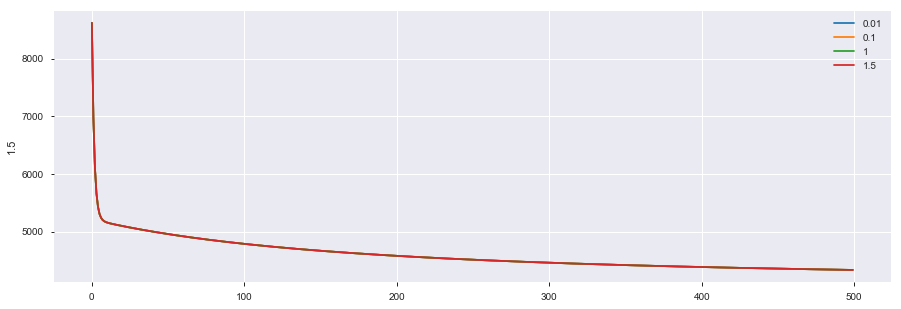

In [141]:
plt.figure(figsize = (15,5))
x_axis = np.arange(500)
sns.lineplot(x = x_axis, y=output[alpha_list[0]],label=alpha_list[0])
sns.lineplot(x = x_axis, y=output[alpha_list[1]],label=alpha_list[1])
sns.lineplot(x = x_axis, y=output[alpha_list[2]],label=alpha_list[2])
sns.lineplot(x = x_axis, y=output[alpha_list[3]],label=alpha_list[3])

plt.show()

# Experiment 1

In [165]:
def gradient_descent(alpha, x, y, numIterations,print_progress = False):
    
    J = np.array([])
    m, n = np.shape(x)
    x = np.c_[ np.ones(m), x]
    theta = np.ones(x.shape[1])
    x_transpose = x.transpose()
    for iter in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        j = np.sum(loss ** 2) / (2 * m)  ## Cost Function
        J = np.append(J, j)
        if print_progress:
            print("iter %s | J: %.3f" % (iter, j)) 
        gradient = np.dot(x_transpose, loss) / m   
        theta = theta - alpha * gradient ## Batch update rule
    theta1 = theta
    y_train_pred = np.dot(x,theta1)
    rms_train = ((((y_train_pred - np.array(y))**2).sum())/m)**0.5 ## root mean square error
    x1 = np.c_[ np.ones(X_test.shape[0]), X_test]
    y_test_pred = np.dot(x1,theta)
    rms_test = ((((y_test_pred - np.array(Y_test))**2).sum())/(x1.shape[0]))**0.5 ## root mean square error
    xyzJ = (alpha,rms_train,rms_test,J)
    return xyzJ

In [193]:
df_exp1 = pd.DataFrame()
J_dict = {}
alpha_list = [0.001,0.01,0.03,0.1,0.3,0.4]
for alpha in alpha_list:
    alpha,rms_train,rms_test,J=gradient_descent(alpha, X_train, Y_train, 1000)
    dict={"alpha" : [alpha],"rms_train" :[rms_train] ,"rms_test":[rms_test]}
    df1=pd.DataFrame(data = dict)
    df_exp1 = df_exp1.append(df1,ignore_index = True)
    J_dict[alpha] = J

In [194]:
df_exp1

alpha   rms_train    rms_test
0  0.001  100.702200  105.884746
1  0.010   95.557713  101.035769
2  0.030   92.671503   98.288025
3  0.100   91.072851   96.789012
4  0.300   89.990406   95.825491
5  0.400         inf         inf

In [195]:
output = pd.DataFrame.from_dict(J_dict, orient='columns')
output.head()

0.001        0.010        0.030        0.100        0.300  \
0  8534.963825  8534.963825  8534.963825  8534.963825  8534.963825   
1  8490.748486  8105.952104  7335.539758  5559.013070  8368.221296   
2  8447.113373  7731.555781  6562.834467  5204.498613  8208.691661   
3  8404.050848  7404.802260  6064.572418  5152.960089  8055.982778   
4  8361.553379  7119.609155  5742.820706  5136.622202  7909.735683   

           0.400  
0    8534.963825  
1   14153.380277  
2   29363.318240  
3   70383.242317  
4  180868.304086

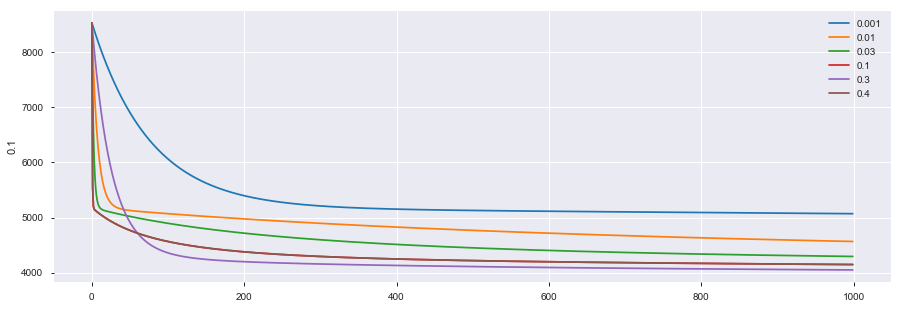

In [197]:
plt.figure(figsize = (15,5))
x_axis = np.arange(1000)
sns.lineplot(x = x_axis, y=output[alpha_list[0]],label=alpha_list[0])
sns.lineplot(x = x_axis, y=output[alpha_list[1]],label=alpha_list[1])
sns.lineplot(x = x_axis, y=output[alpha_list[2]],label=alpha_list[2])
sns.lineplot(x = x_axis, y=output[alpha_list[3]],label=alpha_list[3])
sns.lineplot(x = x_axis, y=output[alpha_list[4]],label=alpha_list[4])
sns.lineplot(x = x_axis, y=output[alpha_list[3]],label=alpha_list[5])

plt.show()


# Experiment 2

### iteration 1000

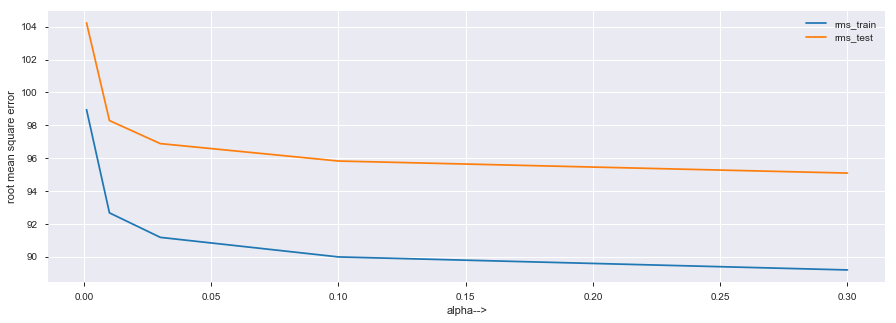

In [192]:
plt.figure(figsize = (15,5))
plt.plot(df_exp1.alpha,df_exp1.rms_train)
plt.plot(df_exp1.alpha,df_exp1.rms_test)
plt.xlabel("alpha-->")
plt.ylabel("root mean square error")
plt.legend()
plt.show()


### iteration 3000

In [198]:
df_exp2 = pd.DataFrame()
J_dict = {}
alpha_list = [0.001,0.01,0.03,0.1,0.3,0.4]
for alpha in alpha_list:
    alpha,rms_train,rms_test,J=gradient_descent(alpha, X_train, Y_train, 3000)
    dict={"alpha" : [alpha],"rms_train" :[rms_train] ,"rms_test":[rms_test]}
    df2=pd.DataFrame(data = dict)
    df_exp2 = df_exp1.append(df2,ignore_index = True)
    J_dict[alpha] = J

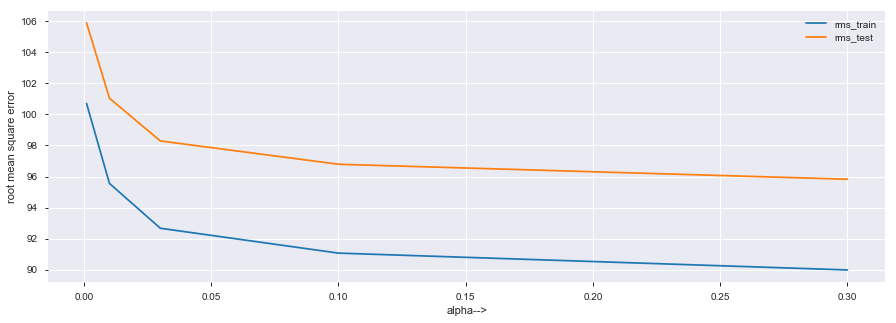

In [199]:
plt.figure(figsize = (15,5))
plt.plot(df_exp1.alpha,df_exp1.rms_train)
plt.plot(df_exp1.alpha,df_exp1.rms_test)
plt.xlabel("alpha-->")
plt.ylabel("root mean square error")
plt.legend()
plt.show()


In [201]:
output = pd.DataFrame.from_dict(J_dict, orient='columns')
output.head()

0.001        0.010        0.030        0.100        0.300  \
0  8534.963825  8534.963825  8534.963825  8534.963825  8534.963825   
1  8490.748486  8105.952104  7335.539758  5559.013070  8368.221296   
2  8447.113373  7731.555781  6562.834467  5204.498613  8208.691661   
3  8404.050848  7404.802260  6064.572418  5152.960089  8055.982778   
4  8361.553379  7119.609155  5742.820706  5136.622202  7909.735683   

           0.400  
0    8534.963825  
1   14153.380277  
2   29363.318240  
3   70383.242317  
4  180868.304086

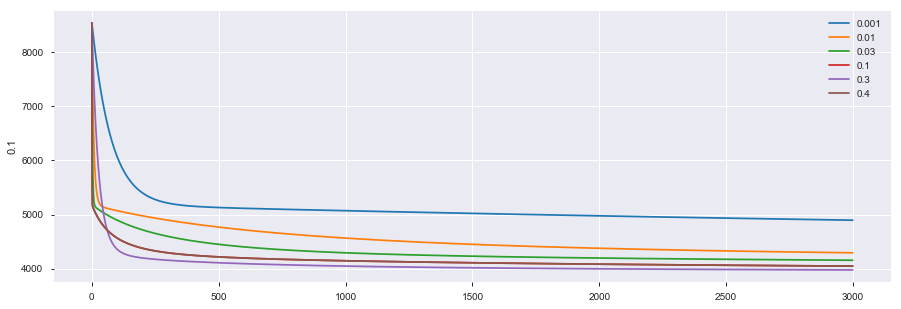

In [202]:
plt.figure(figsize = (15,5))
x_axis = np.arange(3000)
sns.lineplot(x = x_axis, y=output[alpha_list[0]],label=alpha_list[0])
sns.lineplot(x = x_axis, y=output[alpha_list[1]],label=alpha_list[1])
sns.lineplot(x = x_axis, y=output[alpha_list[2]],label=alpha_list[2])
sns.lineplot(x = x_axis, y=output[alpha_list[3]],label=alpha_list[3])
sns.lineplot(x = x_axis, y=output[alpha_list[4]],label=alpha_list[4])
sns.lineplot(x = x_axis, y=output[alpha_list[3]],label=alpha_list[5])

plt.show()

### Best Threshould values alpha = 0.01, Iter = 1000

In [271]:
def gradient_descent(alpha, x, y, numIterations,print_progress = False):
    rms_test = np.array([])
    rms_train = np.array([])
    J = np.array([])
    m, n = np.shape(x)
    x = np.c_[ np.ones(m), x]
    theta = np.ones(x.shape[1])
    x_transpose = x.transpose()
    for iter in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        j = np.sum(loss ** 2) / (2 * m)  ## Cost Function
        J = np.append(J, j)
        if print_progress:
            print("iter %s | J: %.3f" % (iter, j)) 
        gradient = np.dot(x_transpose, loss) / m   
        theta = theta - alpha * gradient ## Batch update rule
        theta1 = theta
        
        y_train_pred = np.dot(x,theta1)
        rms_train_1 = ((((y_train_pred - np.array(y))**2).sum())/m)**0.5 ## root mean square error
        rms_train = np.append(rms_train, rms_train_1)
        
        x1 = np.c_[ np.ones(X_test.shape[0]), X_test]
        y_test_pred = np.dot(x1,theta)
        rms_test_1 = ((((y_test_pred - np.array(Y_test))**2).sum())/(x1.shape[0]))**0.5 ## root mean square error
        rms_test = np.append(rms_test, rms_test_1)
    
        
        
        xyzJ = (alpha,rms_train,rms_test,J)
    return xyzJ

In [272]:

alpha,rms_train,rms_test,J=gradient_descent(0.01, X_train, Y_train, 1000)


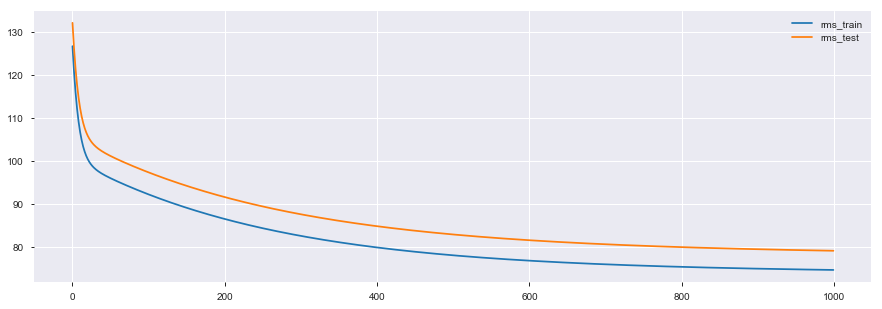

In [273]:
plt.figure(figsize = (15,5))
x_axis = np.arange(1000)
sns.lineplot(x = x_axis, y=rms_train,label='rms_train')
sns.lineplot(x = x_axis, y=rms_test,label='rms_test')


plt.show()

In [274]:
rms_train[999],rms_test[999]

(74.68611913113739, 79.1484277181098)

# Logistic Regression - Target Variable conversion

In [358]:
df['Target'] = df.Appliances>=100
df['Target'] = df.Target.map({True:1,False:0})
df.Target.value_counts()

0    14524
1     5211
Name: Target, dtype: int64

In [281]:
#Splitting the data
Y = df.Target
X = df.drop(['Appliances','Target'],axis = 1)

In [282]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)

#Scaling data from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [283]:
for C in (1,1.5,2,2.5,3,3.5):
    lgm = LogisticRegression(C = C)
    lgm.fit(X_train,Y_train)
    print("Training Accracy with C-",C,round(lgm.score(X_train,Y_train)*100,2),"%")
    print("Testing Accracy with C-",C,round(lgm.score(X_test,Y_test)*100,2),"%\n")

Training Accracy with C- 1 83.08 %
Testing Accracy with C- 1 81.89 %

Training Accracy with C- 1.5 83.3 %
Testing Accracy with C- 1.5 82.17 %

Training Accracy with C- 2 83.35 %
Testing Accracy with C- 2 82.27 %

Training Accracy with C- 2.5 83.39 %
Testing Accracy with C- 2.5 82.22 %

Training Accracy with C- 3 83.39 %
Testing Accracy with C- 3 82.15 %

Training Accracy with C- 3.5 83.37 %
Testing Accracy with C- 3.5 82.18 %



In [285]:
lgm = LogisticRegression(C = 2)
lgm.fit(X_train,Y_train)
print("Training Accracy with C-",C,round(lgm.score(X_train,Y_train)*100,2),"%")
print("Testing Accracy with C-",C,round(lgm.score(X_test,Y_test)*100,2),"%\n")

Training Accracy with C- 3.5 83.35 %
Testing Accracy with C- 3.5 82.27 %



In [308]:
lgm = LogisticRegression(C = 10000,penalty='l1')
lgm.fit(X_train,Y_train)
print("Training Accracy with C-",C,round(lgm.score(X_train,Y_train)*100,2),"%")
print("Testing Accracy with C-",C,round(lgm.score(X_test,Y_test)*100,2),"%\n")
# lgm.coef_.tolist()[0]

Training Accracy with C- 3.5 83.23 %
Testing Accracy with C- 3.5 82.08 %



In [309]:
lst1 = ['T1',        'RH_1',          'T2',
              'RH_2',          'T3',        'RH_3',          'T4',
              'RH_4',          'T5',        'RH_5',          'T6',
              'RH_6',          'T7',        'RH_7',          'T8',
              'RH_8',        'RH_9', 'Press_mm_hg',      'RH_out',
         'Windspeed',  'Visibility',   'Tdewpoint',             2,
                   3,             4,             5,             1,
                   2,             3,             4,             5,
                   6,             7,             8,             9,
                  10,            11,            12,            13,
                  14,            15,            16,            17,
                  18,            19,            20,            21,
                  22,            23,             1,             2,
                   3,             4,             5,             6]
df1 = pd.DataFrame(list(zip(lst1, lgm.coef_.tolist()[0])), 
               columns =['Name', 'val']) 


In [345]:
selected_Columns = list(df1[df1.val>4.8].Name)[0:9]
selected_Columns

['RH_1', 'T3', 'RH_3', 'T8', 9, 10, 11, 12, 17]

# Experiment 3

In [251]:
df.shape

(19735, 57)

In [256]:
np.random.seed(0)
random_column = np.random.randint(0,57,10)
random_column

array([44, 47, 53,  0,  3,  3, 39,  9, 19, 21])

In [257]:
# Linear Regression

In [258]:
#Splitting the data
Y = df.Appliances
X1 = df.drop(['Appliances','Target'],axis = 1)
X = X1.iloc[:,random_column] 

In [260]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)

#Scaling data from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [261]:
alpha,rms_train,rms_test,J=gradient_descent(0.01, X_train, Y_train, 1000)

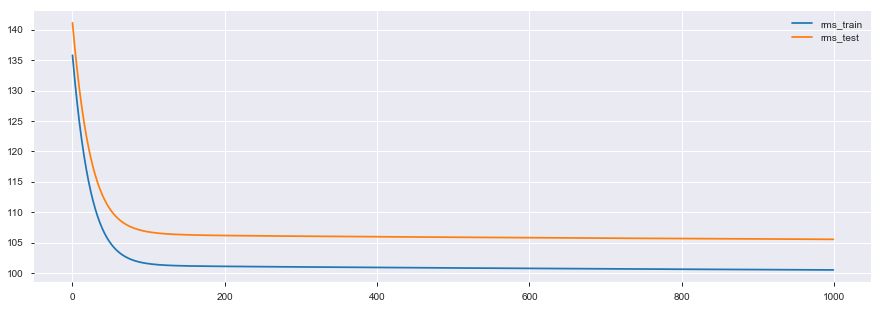

In [262]:
plt.figure(figsize = (15,5))
x_axis = np.arange(1000)
sns.lineplot(x = x_axis, y=rms_train,label='rms_train')
sns.lineplot(x = x_axis, y=rms_test,label='rms_test')


plt.show()

In [267]:
rms_train[999]

100.51336037906974

In [268]:
rms_test[999]

105.54795278983116

In [275]:
#Logistic Regression

In [276]:
Y = df.Target
X1 = df.drop(['Appliances','Target'],axis = 1)
X = X1.iloc[:,random_column] 

In [277]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)

#Scaling data from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [279]:
lgm = LogisticRegression(C = 2)
lgm.fit(X_train,Y_train)
print("Training Accracy with C-",2,round(lgm.score(X_train,Y_train)*100,2),"%")
print("Testing Accracy with C-",2,round(lgm.score(X_test,Y_test)*100,2),"%\n")

Training Accracy with C- 2 75.81 %
Testing Accracy with C- 2 75.12 %



In [280]:
lgm.coef_

array([[ 2.19641638, -1.43694833,  0.29706852,  2.01239175, -0.63319366,
        -0.63319366,  0.2762236 ,  1.30346205,  1.27056168, -0.53303436]])

# Experiment 4


In [347]:
#Splitting the data
Y = df.Appliances
X1 = df.drop(['Appliances','Target'],axis = 1)
X = X1[selected_Columns] 

In [350]:
X.shape

(19735, 9)

In [351]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)

#Scaling data from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [352]:
alpha,rms_train,rms_test,J=gradient_descent(0.01, X_train, Y_train, 1000)

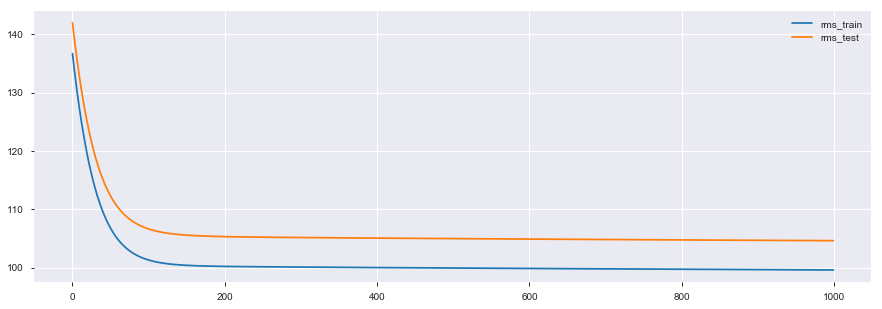

In [353]:
plt.figure(figsize = (15,5))
x_axis = np.arange(1000)
sns.lineplot(x = x_axis, y=rms_train,label='rms_train')
sns.lineplot(x = x_axis, y=rms_test,label='rms_test')


plt.show()

In [354]:
rms_train[999]

99.59542775250125

In [355]:
rms_test[999]

104.61625825351359

In [356]:
# Logistic Regression

In [359]:
Y = df.Target
X1 = df.drop(['Appliances','Target'],axis = 1)
X = X1[selected_Columns] 

In [360]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)

#Scaling data from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [361]:
lgm = LogisticRegression(C = 2)
lgm.fit(X_train,Y_train)
print("Training Accracy with C-",2,round(lgm.score(X_train,Y_train)*100,2),"%")
print("Testing Accracy with C-",2,round(lgm.score(X_test,Y_test)*100,2),"%\n")

Training Accracy with C- 2 74.82 %
Testing Accracy with C- 2 74.35 %



In [362]:
lgm.coef_

array([[ 5.16133495, -0.99572643, -2.25061998,  1.77536074,  0.33253006,
         0.34006345,  0.67297748,  0.69503633,  1.24515605]])